In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.11MB/s]


In [4]:
def get_activation(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "tanh":
        return nn.Tanh()
    else:
        raise ValueError("Unknown activation")



In [5]:
class CNN(nn.Module):
    def __init__(self, activation="relu", use_bn=False, dropout_rate=0.25):
        super(CNN, self).__init__()
        act = get_activation(activation)

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)

        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

        self.activation = act

    def forward(self, x):
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


In [6]:
class MLP(nn.Module):
    def __init__(self, hidden_layers, activation="relu", use_bn=True):
        super(MLP, self).__init__()
        layers = []
        act = get_activation(activation)

        input_size = 784
        for h in hidden_layers:
            layers.append(nn.Linear(input_size, h))
            if use_bn:
                layers.append(nn.BatchNorm1d(h))
            layers.append(act)
            input_size = h

        layers.append(nn.Linear(input_size, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)



In [7]:
def train(model, optimizer, criterion, epochs):
    train_loss, train_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {train_loss[-1]:.4f}, "
              f"Accuracy: {train_acc[-1]:.2f}%")

    return train_loss, train_acc


In [8]:
def test(model):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return 100 * correct / total


In [9]:
def get_optimizer(name, model, lr=0.01):
    if name == "sgd":
        return optim.SGD(model.parameters(), lr=lr)
    elif name == "momentum":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif name == "adam":
        return optim.Adam(model.parameters(), lr=lr)


In [10]:
model = CNN(activation="relu", use_bn=True, dropout_rate=0.25).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer("adam", model, lr=0.001)

loss, acc = train(model, optimizer, criterion, epochs=10)
test_acc = test(model)
print("Final Test Accuracy:", test_acc)


Epoch [1/10] Loss: 0.1248, Accuracy: 96.14%
Epoch [2/10] Loss: 0.0491, Accuracy: 98.51%
Epoch [3/10] Loss: 0.0352, Accuracy: 98.87%
Epoch [4/10] Loss: 0.0272, Accuracy: 99.14%
Epoch [5/10] Loss: 0.0225, Accuracy: 99.28%
Epoch [6/10] Loss: 0.0199, Accuracy: 99.33%
Epoch [7/10] Loss: 0.0146, Accuracy: 99.51%
Epoch [8/10] Loss: 0.0124, Accuracy: 99.57%
Epoch [9/10] Loss: 0.0121, Accuracy: 99.61%
Epoch [10/10] Loss: 0.0091, Accuracy: 99.68%
Final Test Accuracy: 98.86


In [11]:
model = MLP([512, 256, 128], activation="relu", use_bn=True).to(device)
optimizer = get_optimizer("sgd", model, lr=0.1)

loss, acc = train(model, optimizer, criterion, epochs=20)
test_acc = test(model)
print("Final Test Accuracy:", test_acc)


Epoch [1/20] Loss: 0.1867, Accuracy: 94.63%
Epoch [2/20] Loss: 0.0764, Accuracy: 97.64%
Epoch [3/20] Loss: 0.0512, Accuracy: 98.39%
Epoch [4/20] Loss: 0.0380, Accuracy: 98.77%
Epoch [5/20] Loss: 0.0286, Accuracy: 99.11%
Epoch [6/20] Loss: 0.0239, Accuracy: 99.20%
Epoch [7/20] Loss: 0.0161, Accuracy: 99.51%
Epoch [8/20] Loss: 0.0114, Accuracy: 99.67%
Epoch [9/20] Loss: 0.0120, Accuracy: 99.64%
Epoch [10/20] Loss: 0.0108, Accuracy: 99.65%
Epoch [11/20] Loss: 0.0078, Accuracy: 99.76%
Epoch [12/20] Loss: 0.0078, Accuracy: 99.79%
Epoch [13/20] Loss: 0.0064, Accuracy: 99.81%
Epoch [14/20] Loss: 0.0048, Accuracy: 99.88%
Epoch [15/20] Loss: 0.0051, Accuracy: 99.87%
Epoch [16/20] Loss: 0.0049, Accuracy: 99.85%
Epoch [17/20] Loss: 0.0042, Accuracy: 99.88%
Epoch [18/20] Loss: 0.0029, Accuracy: 99.93%
Epoch [19/20] Loss: 0.0036, Accuracy: 99.91%
Epoch [20/20] Loss: 0.0031, Accuracy: 99.91%
Final Test Accuracy: 98.51


In [12]:
model = MLP([256], activation="relu", use_bn=True).to(device)
optimizer = get_optimizer("adam", model, lr=0.001)

loss, acc = train(model, optimizer, criterion, epochs=15)
test_acc = test(model)
print("Final Test Accuracy:", test_acc)


Epoch [1/15] Loss: 0.2278, Accuracy: 93.59%
Epoch [2/15] Loss: 0.1017, Accuracy: 97.07%
Epoch [3/15] Loss: 0.0669, Accuracy: 98.04%
Epoch [4/15] Loss: 0.0522, Accuracy: 98.47%
Epoch [5/15] Loss: 0.0406, Accuracy: 98.77%
Epoch [6/15] Loss: 0.0335, Accuracy: 98.94%
Epoch [7/15] Loss: 0.0286, Accuracy: 99.16%
Epoch [8/15] Loss: 0.0221, Accuracy: 99.36%
Epoch [9/15] Loss: 0.0197, Accuracy: 99.41%
Epoch [10/15] Loss: 0.0177, Accuracy: 99.47%
Epoch [11/15] Loss: 0.0147, Accuracy: 99.58%
Epoch [12/15] Loss: 0.0154, Accuracy: 99.51%
Epoch [13/15] Loss: 0.0132, Accuracy: 99.61%
Epoch [14/15] Loss: 0.0111, Accuracy: 99.67%
Epoch [15/15] Loss: 0.0112, Accuracy: 99.64%
Final Test Accuracy: 98.04


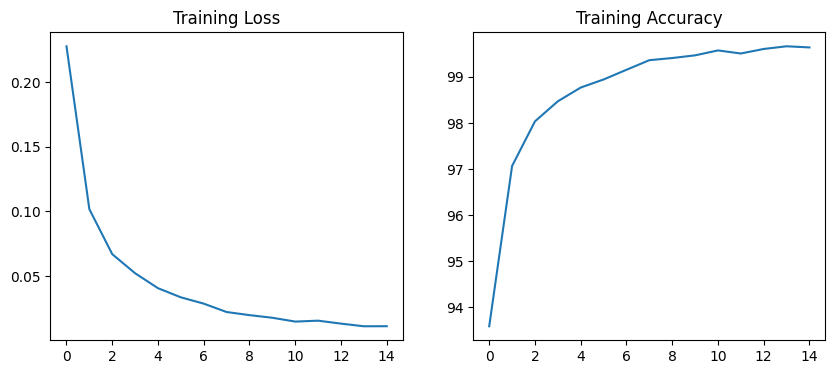

In [13]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loss)
plt.title("Training Loss")

plt.subplot(1,2,2)
plt.plot(acc)
plt.title("Training Accuracy")

plt.show()


In [14]:
results = pd.DataFrame([
    ["CNN-1", "ReLU", "Adam", 10, test_acc],
    ["MLP-1", "ReLU", "SGD", 20, test_acc],
    ["MLP-2", "ReLU", "Adam", 15, test_acc]
], columns=["Model", "Activation", "Optimizer", "Epochs", "Final Accuracy"])

results


,Model,Activation,Optimizer,Epochs,Final Accuracy
0,CNN-1,ReLU,Adam,10,98.04
1,MLP-1,ReLU,SGD,20,98.04
2,MLP-2,ReLU,Adam,15,98.04


Task 2


In [ ]:
model_sgd = CNN(
    activation="relu",
    use_bn=True,
    dropout_rate=0.25
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

loss_sgd, acc_sgd = train(model_sgd, optimizer_sgd, criterion, epochs=10)
test_acc_sgd = test(model_sgd)

print("Test Accuracy (SGD):", test_acc_sgd)


Epoch [1/10] Loss: 0.1963, Accuracy: 94.39%
Epoch [2/10] Loss: 0.0694, Accuracy: 97.93%
Epoch [3/10] Loss: 0.0514, Accuracy: 98.50%
Epoch [4/10] Loss: 0.0425, Accuracy: 98.74%
Epoch [5/10] Loss: 0.0362, Accuracy: 98.95%
Epoch [6/10] Loss: 0.0312, Accuracy: 99.08%
Epoch [7/10] Loss: 0.0284, Accuracy: 99.16%


In [ ]:
model_momentum = CNN(
    activation="relu",
    use_bn=True,
    dropout_rate=0.25
).to(device)

optimizer_momentum = optim.SGD(
    model_momentum.parameters(),
    lr=0.01,
    momentum=0.9
)

loss_mom, acc_mom = train(model_momentum, optimizer_momentum, criterion, epochs=10)
test_acc_mom = test(model_momentum)

print("Test Accuracy (SGD + Momentum):", test_acc_mom)


In [ ]:
model_adam = CNN(
    activation="relu",
    use_bn=True,
    dropout_rate=0.25
).to(device)

optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

loss_adam, acc_adam = train(model_adam, optimizer_adam, criterion, epochs=10)
test_acc_adam = test(model_adam)

print("Test Accuracy (Adam):", test_acc_adam)


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(loss_sgd, label="SGD")
plt.plot(loss_mom, label="SGD + Momentum")
plt.plot(loss_adam, label="Adam")

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Task 2: Optimizer Comparison (ReLU)")
plt.legend()
plt.show()


In [ ]:
task2_results = pd.DataFrame([
    ["ReLU", "SGD", 10, test_acc_sgd],
    ["ReLU", "SGD + Momentum", 10, test_acc_mom],
    ["ReLU", "Adam", 10, test_acc_adam]
], columns=["Activation", "Optimizer", "Epochs", "Final Test Accuracy"])

task2_results


Task 3


Scenario 1: WITHOUT BatchNorm & WITHOUT Dropout

In [ ]:
model_no_bn_no_do = CNN(
    activation="relu",
    use_bn=False,
    dropout_rate=0.0
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_no_bn_no_do.parameters(), lr=0.001)

loss1, acc1 = train(model_no_bn_no_do, optimizer, criterion, epochs=10)
test_acc1 = test(model_no_bn_no_do)

print("Test Accuracy (No BN, No Dropout):", test_acc1)


Scenario 2: WITHOUT BN, Dropout = 0.1


In [ ]:
model_no_bn_do = CNN(
    activation="relu",
    use_bn=False,
    dropout_rate=0.1
).to(device)

optimizer = optim.Adam(model_no_bn_do.parameters(), lr=0.001)

loss2, acc2 = train(model_no_bn_do, optimizer, criterion, epochs=10)
test_acc2 = test(model_no_bn_do)

print("Test Accuracy (No BN, Dropout=0.1):", test_acc2)


Scenario 3: WITH BatchNorm & Dropout = 0.25

In [ ]:
model_bn_do = CNN(
    activation="relu",
    use_bn=True,
    dropout_rate=0.25
).to(device)

optimizer = optim.Adam(model_bn_do.parameters(), lr=0.001)

loss3, acc3 = train(model_bn_do, optimizer, criterion, epochs=10)
test_acc3 = test(model_bn_do)

print("Test Accuracy (BN + Dropout=0.25):", test_acc3)


Task 3 – Loss Curve Comparison

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(loss1, label="No BN, No Dropout")
plt.plot(loss2, label="No BN, Dropout 0.1")
plt.plot(loss3, label="BN + Dropout 0.25")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Task 3: Effect of BN and Dropout")
plt.legend()
plt.show()


In [ ]:
task3_results = pd.DataFrame([
    ["No BN, No Dropout", "ReLU", "Adam", 10, test_acc1],
    ["No BN, Dropout=0.1", "ReLU", "Adam", 10, test_acc2],
    ["BN + Dropout=0.25", "ReLU", "Adam", 10, test_acc3]
], columns=["Experiment", "Activation", "Optimizer", "Epochs", "Final Accuracy"])

task3_results
